In [1]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [2]:
def calculate_coeff(data, min_i, max_i, log=False, plot=False, show=True):
    data = np.array(data)
    data_clean = data[np.all(~np.isnan(data), axis=1)]
    d, ll = tuple(zip(*data_clean))

    d = d[min_i:max_i]
    ll = ll[min_i:max_i]

    d = np.array(d).reshape(-1,1)
    ll = np.array(ll)
    
    if log:
        d = np.log(d)

    regr = linear_model.LinearRegression()
    regr.fit(d, ll)
    ll_pred = regr.predict(d)

    if plot:
        plt.plot(d, regr.predict(d), label="prediction", c='r', alpha=0.5)
        plt.plot(d, ll, 'o-', alpha=0.5)
    if show:
        plt.show()
        
    return regr.coef_[0]


In [6]:
image_size = 8
n_pixel = image_size * image_size * 1
mul = np.log(2) * n_pixel

to_plot = []
for f in sorted(glob("../ll/*dataset#point_2d*")):
    txt = pd.read_csv(f, sep=" ", header=None)
    noise, pz, logdet = txt.mean()
    to_plot.append([noise, pz + logdet])
#     print(noise)
    
print(to_plot)
to_plot = np.array(to_plot)
to_plot[:, 1] *= mul
coef = -calculate_coeff(to_plot, 0, len(to_plot), log=True, plot=True)
print(n_pixel - coef)
length = 2
dims = []
for i in range(0, len(to_plot)-length+1):
    coef = -calculate_coeff(to_plot, i, i + length, log=True, plot=False)
    print(i, i + length, n_pixel - coef)
    dims.append(n_pixel - coef)
plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), dims)

[]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

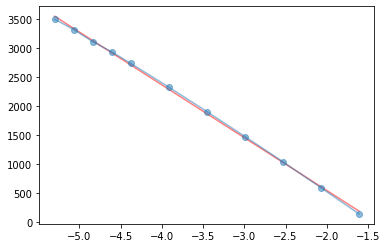

111.521148318408
0 2 251.42159448429493
1 3 117.78473188976807
2 4 258.4305566056606
3 5 160.31752375857843
4 6 133.32748065276553
5 7 110.79026299928614
6 8 88.572889129077
7 9 77.18390382805535
8 10 52.159152366686385
9 11 43.167876340500584


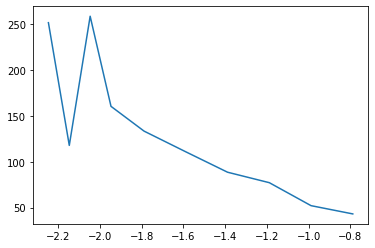

In [75]:
image_size = 32
n_pixel = image_size * image_size * 1
mul = np.log(2) * n_pixel

to_plot = []
for f in sorted(glob("../ll/*dataset#mnist*")):
    txt = pd.read_csv(f, sep=" ", header=None)
    noise, pz, logdet = txt.mean()
    to_plot.append([noise, pz + logdet])
#     print(noise)
    
to_plot = np.array(to_plot)
to_plot[:, 1] *= mul
coef = -calculate_coeff(to_plot, 0, len(to_plot), log=True, plot=True)
print(n_pixel - coef)
length = 2
dims = []
for i in range(0, len(to_plot)-length+1):
    coef = -calculate_coeff(to_plot, i, i + length, log=True, plot=False)
    print(i, i + length, n_pixel - coef)
    dims.append(n_pixel - coef)
plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), dims)

0.005000000000000004
0.0062999999999999836
0.007929999999999994
0.009990000000000027
0.012569999999999987
0.019940000000000027
0.031620000000000065
0.050150000000000035
0.07953000000000009
0.1261200000000002
0.19999999999999962


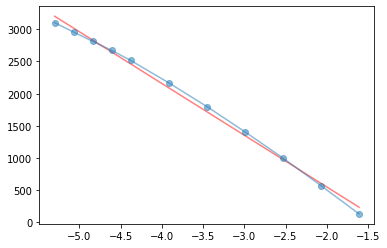

219.3277797424339
0 2 397.3868888959497
1 3 393.96758320180436
2 4 417.14284907028525
3 5 341.96363551188506
4 6 269.76994966431903
5 7 225.65243111596203
6 8 174.3474661591539
7 9 138.62056758421522
8 10 93.05690747099072
9 11 70.26847128024679


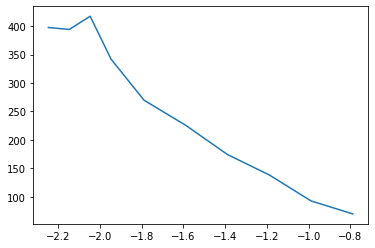

In [77]:
image_size = 32
n_pixel = image_size * image_size * 1
mul = np.log(2) * n_pixel

to_plot = []
for f in sorted(glob("../ll/*dataset#fashion_mnist*")):
#     print(f)
    txt = pd.read_csv(f, sep=" ", header=None)
    noise, pz, logdet = txt.mean()
    to_plot.append([noise, pz + logdet])
    print(noise)
    
to_plot = np.array(to_plot)
to_plot[:, 1] *= mul
coef = -calculate_coeff(to_plot, 0, len(to_plot), log=True, plot=True)
print(n_pixel - coef)
length = 2
dims = []
for i in range(0, len(to_plot)-length+1):
    coef = -calculate_coeff(to_plot, i, i + length, log=True, plot=False)
    print(i, i + length, n_pixel - coef)
    dims.append(n_pixel - coef)
plt.plot(np.log10((to_plot[:-1, 0] + to_plot[1:, 0])/2), dims)

In [30]:
32*32

1024